In [1]:
# Ressources: https://github.com/slundberg/shap

# Census income classification with LightGBM
This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit github.

Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP (arXiv paper) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions.

In [2]:
! pip install -U lightgbm
! pip install -U shap

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached lightgbm-3.3.3-py3-none-manylinux1_x86_64.whl (2.0 MB)
Keyring is skipped due to an exception: 'keyring.backends'
  Using cached shap-0.41.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (569 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sagemaker 2.116.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 5.0.0 which is incompatible

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [5]:
y_display

array([False, False, False, ..., False, False,  True])

In [6]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [7]:
y

array([False, False, False, ..., False, False,  True])

## Train Test Split

In [8]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [9]:
# Build training and testing dataset for LGB
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

## Train Model

In [10]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params=params, 
                  train_set=d_train,
                  num_boost_round=1000, 
                  valid_sets=[d_test], 
                  early_stopping_rounds=50, 
                  verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


## Explain predictions
Here we use the Tree SHAP implementation integrated into Light GBM to explain the entire dataset (32561 samples).

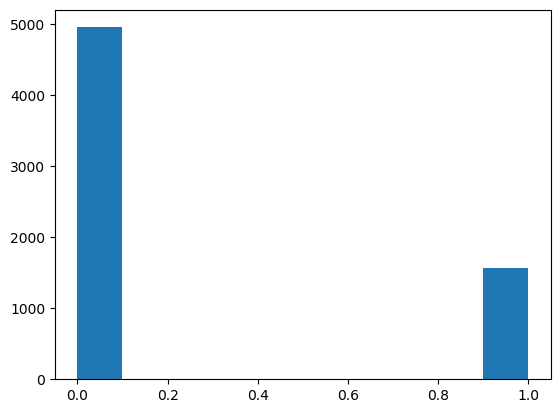

In [11]:
plt.hist(np.where(y_test == False, 0, 1))
plt.show()

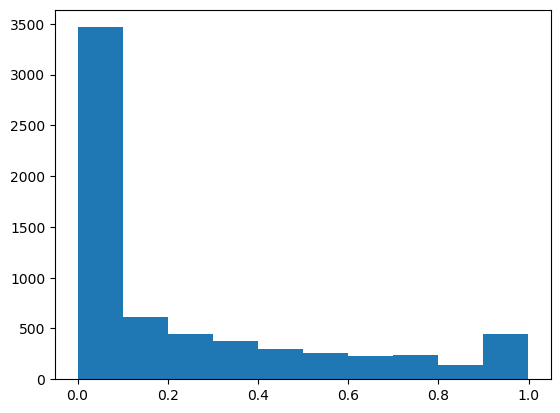

In [12]:
plt.hist(model.predict(X_test))
plt.show()

### Explain predictions using the Tree Explainer Object

In [13]:
# use the fast tree explainer for tree models
explainer = shap.TreeExplainer(model=model, 
                               data=X_train[0:100], # background dataset
                               feature_perturbation="interventional",
                               model_output="probability")
shap_values = explainer.shap_values(X_test)

100%|===================| 6489/6513 [01:08<00:00]        

In [14]:
shap_values.shape

(6513, 12)

### Visualize a single prediction
Note that we use the “display values” data frame so we get nice strings instead of category codes.

In [15]:
observation = 0

y_test[observation]

False

In [16]:
model.predict(X_test.iloc[observation,:])

Converting data to scipy sparse matrix.


array([0.03354713])

In [17]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

### Visualize many predictions
To keep the browser happy we only visualize 1,000 individuals.

In [18]:
nobservations = 100
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[:nobservations,:], 
                features=X_display.iloc[:nobservations,:])

### Try different exlplainers

In [19]:
explainer = shap.Explainer(model=model, 
                           masker=X_train[0:100], # background dataset
                           algorithm="tree",
                           model_output="probability")
shap_values = explainer.shap_values(X_test)

 99%|===================| 6442/6513 [01:09<00:00]        

In [20]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

In [21]:
%%time
# use an alternative model agnostic explainer; 
explainer = shap.SamplingExplainer(model=model.predict, 
                                   data=X_train, # background dataset
                                  )
shap_values = explainer.shap_values(X_test[:10])

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



CPU times: user 1min 40s, sys: 216 ms, total: 1min 40s
Wall time: 1min 35s


In [22]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

In [44]:
%%time
# use an alternative model agnostic explainer; the kernel explainer is also used by sagemaker --> slow but model agnostic!
explainer = shap.KernelExplainer(model=model.predict, 
                                 data=X_train[:100], # background dataset
                                  )
shap_values = explainer.shap_values(X_test[:10])

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



CPU times: user 1min 15s, sys: 669 ms, total: 1min 15s
Wall time: 43.4 s


In [46]:
shap_values.shape

(10, 12)

In [49]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

## Visualization Deep-Dive

In [50]:
# use the fast tree explainer for tree models
explainer = shap.TreeExplainer(model=model, 
                               data=X_train[0:100], # background dataset
                               feature_perturbation="interventional",
                               model_output="probability")
shap_values = explainer.shap_values(X_test)

 99%|===================| 6453/6513 [01:11<00:00]        

In [53]:
shap_values.shape

(6513, 12)

In [57]:
X_test.columns.to_list()

['Age',
 'Workclass',
 'Education-Num',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Country']

### Explain Multiple Decisions

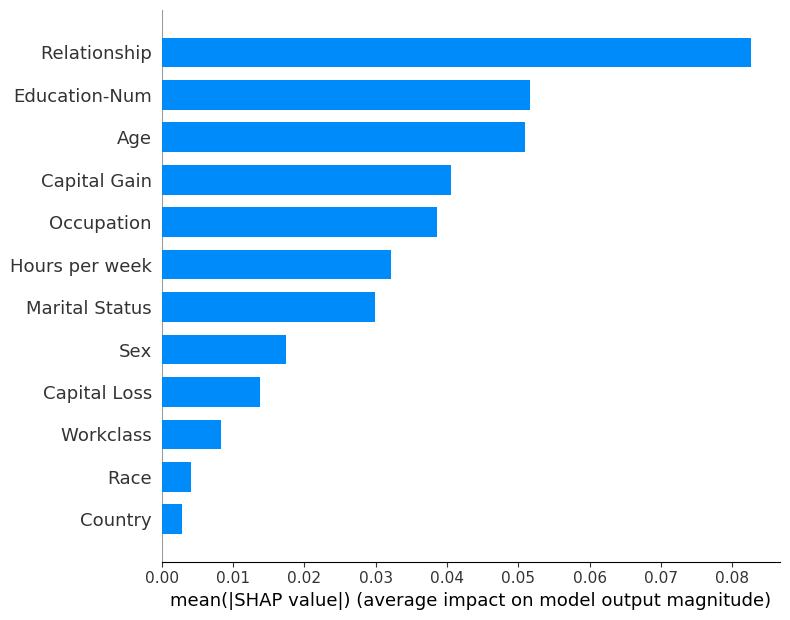

In [63]:
# summary plot: bar plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="bar")

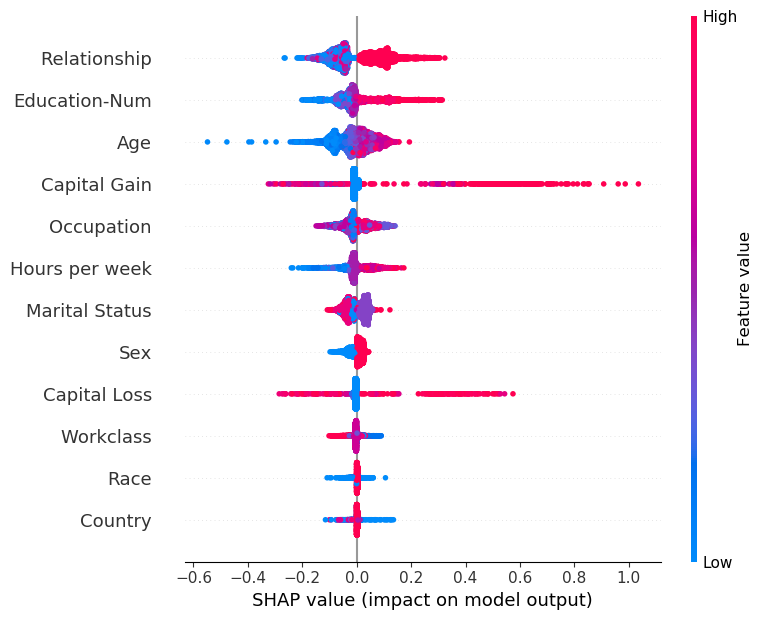

In [64]:
# summary plot: dot plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="dot")

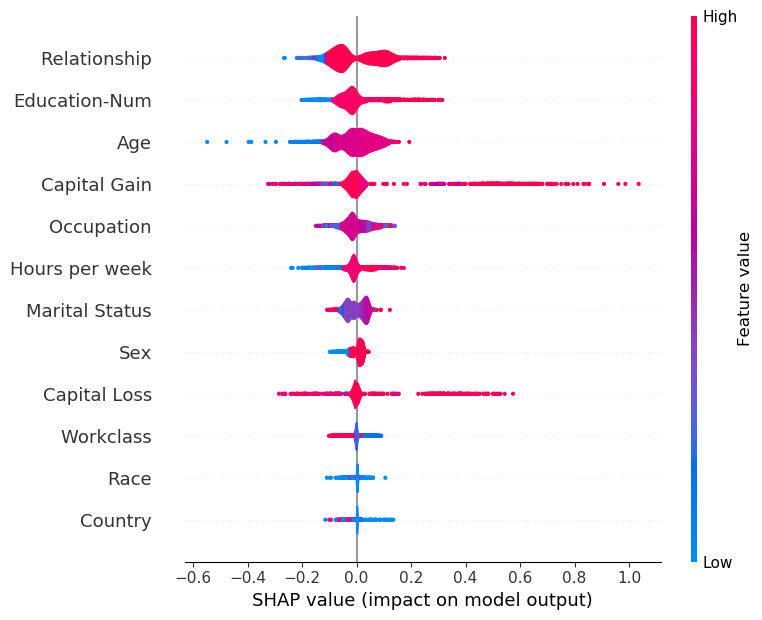

In [65]:
# summary plot: violin plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="violin")

### Explain Single Desicions

In [68]:
# explain single prediction
observation = 1
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

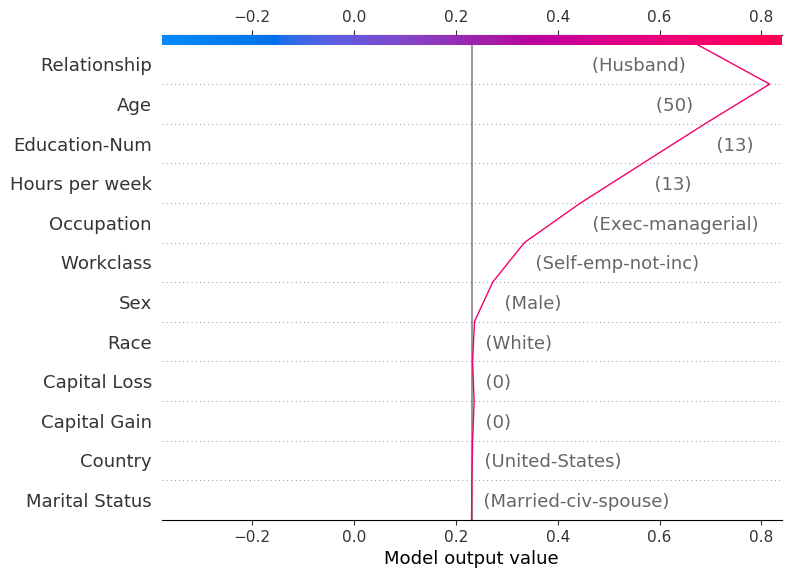

In [69]:
# explain single prediction
shap.decision_plot(base_value=explainer.expected_value, 
                    shap_values=shap_values[observation,:], 
                    features=X_display.iloc[observation,:])

In [70]:
shap.waterfall_plot(shap_values)

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'